In [1]:
import pandas as pd

# Part II (Vatic)

In [2]:
data = pd.read_csv("emissions_CO2.csv")
data.shape

(731, 6)

In [3]:
data.head()

,BUS UID,Fuel,GEN UID,Plant Code,Unit Type,CO2 Emissions Lbs/MWh
0,111218_1,NUC (Nuclear),6251_Nuclear_2,6251,Nuclear,0.000000
1,111217_1,NUC (Nuclear),6251_Nuclear_1,6251,Nuclear,0.000000
2,150441_1,NUC (Nuclear),6145_Nuclear_1,6145,Nuclear,0.000000
3,150442_1,NUC (Nuclear),6145_Nuclear_2,6145,Nuclear,0.000000
4,210334_1,SUB (Subbituminous Coal),56611_ConventionalSteamCoal_S01,56611,Conventional Steam Coal,2031.776627


In [4]:
data["Fuel"].unique()

array(['NUC (Nuclear)', 'SUB (Subbituminous Coal)', 'LIG (Lignite Coal)',
       'NG (Natural Gas)', 'WND (Wind)', 'SUN (Solar)',
       'WDS (Wood/Wood Waste Solids)', 'OG (Other Gas)', 'WAT (Water)',
       'PUR (Purchased Steam)', 'OTH (Other)',
       'AB (Agricultural By-Products)',
       'MWH (Electricity use for Energy Storage)', 'WH (Waste Heat)',
       'PC (Petroleum Coke)'], dtype=object)

In [8]:
data.groupby("Fuel").size().sort_values(ascending = False)

Fuel
NG (Natural Gas)                            472
WND (Wind)                                  153
SUN (Solar)                                  36
WAT (Water)                                  22
SUB (Subbituminous Coal)                     15
LIG (Lignite Coal)                            8
WH (Waste Heat)                               5
NUC (Nuclear)                                 4
OTH (Other)                                   4
OG (Other Gas)                                3
PUR (Purchased Steam)                         3
MWH (Electricity use for Energy Storage)      2
PC (Petroleum Coke)                           2
AB (Agricultural By-Products)                 1
WDS (Wood/Wood Waste Solids)                  1
dtype: int64

In [10]:
data.groupby("Unit Type").size().sort_values(ascending = False)

Unit Type
Natural Gas Fired Combined Cycle          255
Onshore Wind Turbine                      153
Natural Gas Fired Combustion Turbine      114
Natural Gas Internal Combustion Engine     57
Natural Gas Steam Turbine                  45
Solar Photovoltaic                         36
Conventional Steam Coal                    23
Conventional Hydroelectric                 22
All Other                                   8
Batteries                                   6
Nuclear                                     4
Other Gases                                 4
Petroleum Coke                              2
Other Waste Biomass                         1
Wood/Wood Waste Biomass                     1
dtype: int64

# PART 2 (Intensity Control)

In [56]:
import hjbSolver as hjb
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [63]:
def my_plot_surface(x, y, z, title = ""):
    fig, ax = plt.subplots(subplot_kw = {"projection": "3d"})
    surf = ax.plot_surface(x, y, z, cmap = cm.coolwarm)
    plt.xlabel('S')
    plt.ylabel('X')
    #? Label z axis
    fig.colorbar(surf)
    plt.title(title)
    plt.show()

## Base Case Analysis

In [ ]:
#? Issues
# - V should be lowest when S is highest and X is lowest right?
# - Tech 4 missing?

### 1. Run the base-case script.

In [81]:
delta_A, beta_A, rho_A = 3, 2, 0.2
delta_B, beta_B, rho_B = 2, 2, 0.2
delta_C, beta_C, rho_C = 5, 2, 0.2
delta_D, beta_D, rho_D = -1, 2, 0.2

delta_vec = np.array([delta_A, delta_B, delta_C]) # output
beta_vec = np.array([beta_A, beta_B, beta_C]) # cost convexity
rho_vec = np.array([rho_A, rho_B, rho_C]) # cost linearity

T = 5 # planning horizon
r = 0.02 # discount rate (2%)
lambdaX = 0.4 # Demand growth rate

I = 50 # supply nodes
J = 50 # demand nodes
s_min = 0.1
ds = 1 # supply step
dx = 1 # demand step

output = hjb.solve_hjb(T, r, lambdaX, dx, ds, s_min, I, J, delta_vec, beta_vec, rho_vec, 
              tech_names=None, s_eps=1e-12, verbose=True)
output.keys()

  Solving HJB: T=5, r=0.02, λ_X=0.4
  Grid: I=50, J=50, ds=1, dx=1
  Integrating HJB backward in time...
  ✓ Integration successful


In [83]:
# LambdaStar0_sum = sum of LambdaStar0_j? only 3 LambdaStar0_j because D has negative output (LambdaStar measures the revenue)
# DeltaS_v has 3D output, one 51x51 for each technology
# price_grid same for all
# D not there in tech names (last one)

# All matrices are I x J => Supply x Demand
S = output['S']
X = output['X']
V0 = output['V0']
LambdaStar0_j = output['LambdaStar0_j']
LambdaStar0_sum = output['LambdaStar0_sum']
tech_names = output['tech_names']
num_scenarios = len(tech_names)
LambdaStar0_j.shape

(51, 51, 3)

### 2. Plot the value function surface.

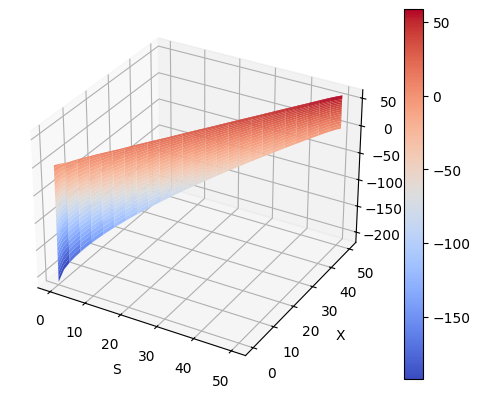

In [73]:
my_plot_surface(S, X, V0)

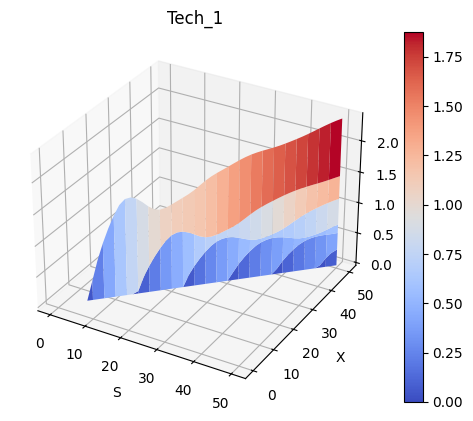

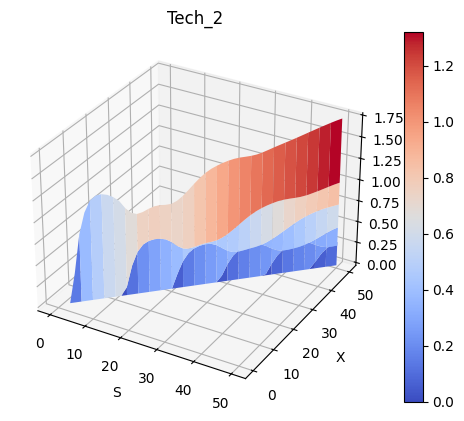

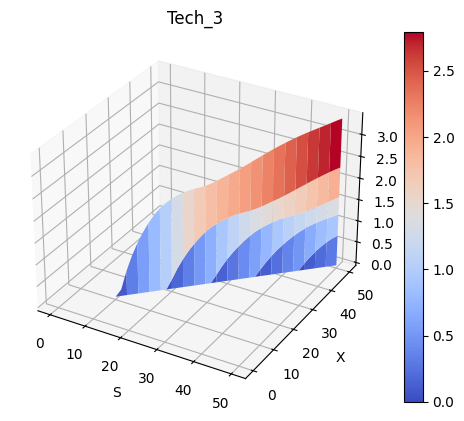

In [74]:
for i in range(num_scenarios):
    my_plot_surface(S, X, LambdaStar0_j[:, :, i], title = tech_names[i])
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # surf = ax.plot_surface(output['S'], output['X'], lambdaStar0_data[:, :, i])
    # plt.xlabel('S')
    # plt.ylabel('X')
    # #? Label z axis
    # plt.title(output["tech_names"][i])
    # plt.show()
    # #? Improve the graph

#### (a)

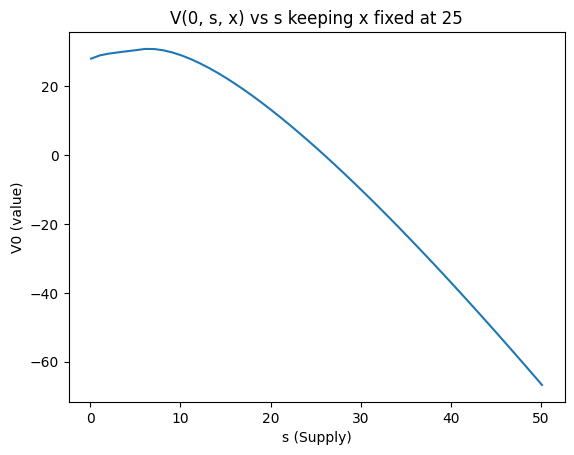

In [45]:
X_val_index = len(X)//2
plt.plot(S, V0[:, X_val_index])
plt.xlabel("s (Capacity)")
plt.ylabel("V0 (value)")
plt.title(f"V(0, s, x) vs s keeping x fixed at {X[X_val_index]}")
plt.show()

##### 
- V is generally decreasing in capacity; so as capacity increases, value decreases indicating that the marginal value of additional/incremental capacity is negative! (Although in this case, to be precise, the value function is non monotone, it increases for smaller values of capacity i.e. when capacity is small, increasing capacity increases value; however, for larger capacity, it decreases.)
- The curvature is negative, supporting the law of diminishing returns; #? Why so?

#### (b)

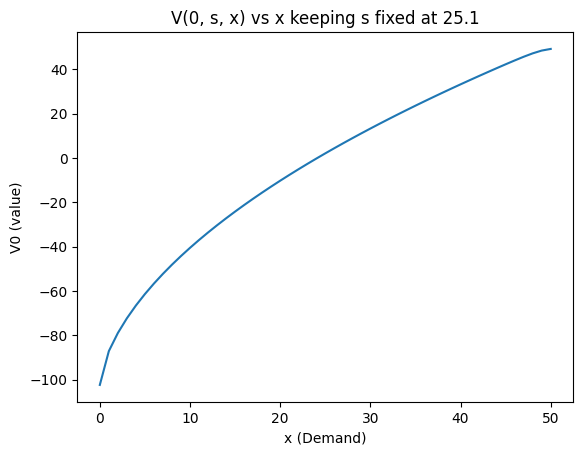

In [46]:
S_val_index = len(S)//2
plt.plot(X, V0[S_val_index, :])
plt.xlabel("x (Demand)")
plt.ylabel("V0 (value)")
plt.title(f"V(0, s, x) vs x keeping s fixed at {S[S_val_index]}")
plt.show()

##### 
- As seen, the value function is increasing in the demand, indicating that the marginal value addition of an incremental unit of demand is positive!
- However, the curvature is negative (convexity < 0 i.e. the function is concave), reinforcing the law of diminishing returns!
#? Why so?

### 3. Cross-sections in demand.

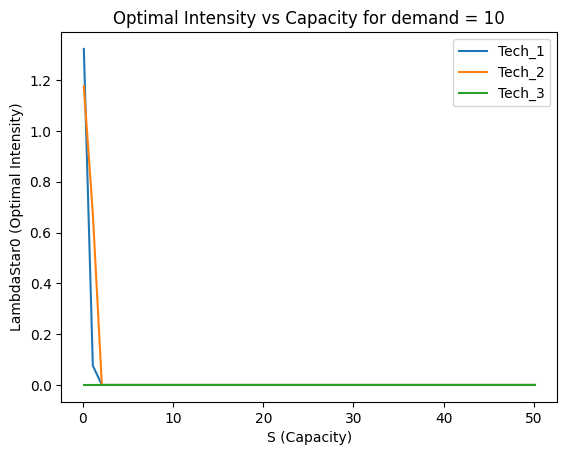

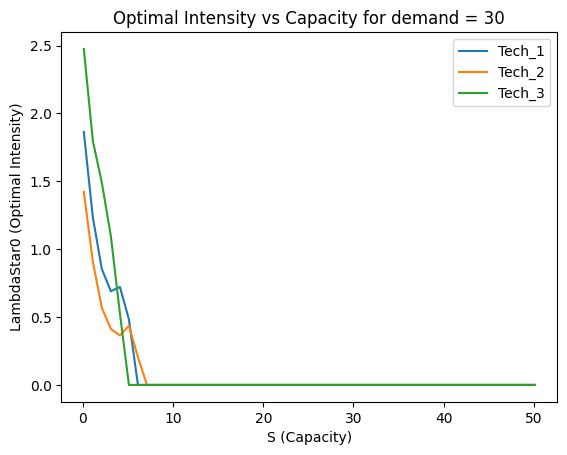

In [51]:
for x in [10, 30]:
    for tech_index in range(LambdaStar0_j.shape[2]):
        plt.plot(S, LambdaStar0_j[:, x, tech_index], label = f"{tech_names[tech_index]}")
    plt.xlabel("S (Capacity)")
    plt.ylabel("LambdaStar0 (Optimal Intensity)")
    plt.legend()
    plt.title(f"Optimal Intensity vs Capacity for demand = {x}")
    plt.show()

##### 
- As lambda increases, cost increases! So, lambda can be considered as a measure of cost (lambda i.e. intensity is a measure of the investment since the investment is controlled via the intensity)
- When x = 10, assuming we start from time 0 and capacity 0, the highest increment in capacity is from Tech_3 (5 units) and at s = 0, it has the lowest intensity (or the lowest cost). So, Tech_3 is deployed first.
- When x = 30, the ordering of intensities changes as Tech_2 < Tech_1 < Tech_3 (indicating that Tech_3 (which has the highest delta) has the highest cost now). So, ideally, one would prefer technology with the highest delta per unit cost incurred (i.e. delta/C) but if we are to just compare based on C (proportional to lambda), we would prefer technology with the lowest C or the lowest lambda i.e. Tech_2 #? How to find delta/C?

## Policy Implications and Subsidy Design

### 1. Solve the HJB under each policy scenario.

In [75]:
delta_A_1, beta_A_1, rho_A_1 = 3, 2, 0.2
delta_A_2, beta_A_2, rho_A_2 = 3, 2, 0.1
delta_A_3, beta_A_3, rho_A_3 = 3, 1.6, 0.2
delta_A_4, beta_A_4, rho_A_4 = 3, 1.8, 0.15

delta_vec = np.array([delta_A_1, delta_A_2, delta_A_3, delta_A_4]) # output
beta_vec = np.array([beta_A_1, beta_A_2, beta_A_3, beta_A_4]) # cost convexity
rho_vec = np.array([rho_A_1, rho_A_2, rho_A_3, rho_A_4]) # cost linearity

T = 5 # planning horizon
r = 0.02 # discount rate (2%)
lambdaX = 0.4 # Demand growth rate

I = 50 # supply nodes
J = 50 # demand nodes
s_min = 0.1
ds = 1 # supply step
dx = 1 # demand step

output = hjb.solve_hjb(T, r, lambdaX, dx, ds, s_min, I, J, delta_vec, beta_vec, rho_vec, 
              tech_names=None, s_eps=1e-12, verbose=True)


  Solving HJB: T=5, r=0.02, λ_X=0.4
  Grid: I=50, J=50, ds=1, dx=1
  Integrating HJB backward in time...
  ✓ Integration successful


In [79]:
S = output['S']
X = output['X']
V0 = output['V0']
LambdaStar0_j = output['LambdaStar0_j']
LambdaStar0_sum = output['LambdaStar0_sum']
tech_names = output['tech_names']
num_scenarios = LambdaStar0_j.shape[2]
scenario_names = ["Baseline", "Subsidize ρ", "Subsidize β", "Subsidize both"]

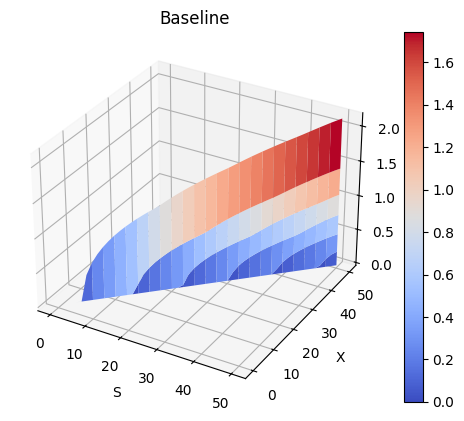

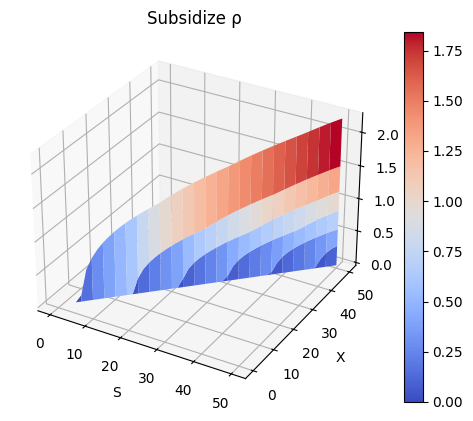

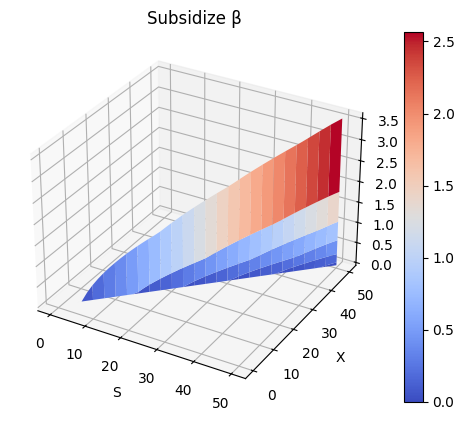

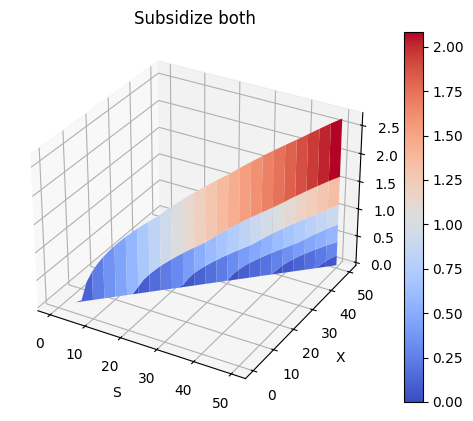

In [80]:
for i in range(num_scenarios):
    my_plot_surface(S, X, LambdaStar0_j[:, :, i], title = scenario_names[i])

### 2. Pointwise subsidy effectiveness comparison at selected states.

##### Expected that as subsidy increases, investment increases; hence lambda increases!

### 3. Connection to real-world renewable policies.

##### What are the closest such real world policies?